In [1]:
from datetime import datetime, timedelta,date
import pandas as pd
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [2]:
df = pd.read_csv('Customer.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12-01-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12-01-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12-01-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12-01-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12-01-2010 08:26,3.39,17850.0,United Kingdom


In [3]:
df.shape

(541909, 8)

In [4]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
df1=df.dropna(subset=['CustomerID','Description'] , inplace=True)

In [6]:
df.shape

(406829, 8)

In [7]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [8]:
df.shape

(406829, 8)

In [9]:
df['InvoiceDate'].replace('12/13/2010 9:02', '12-13-2010 9:02')

0         12-01-2010 08:26
1         12-01-2010 08:26
2         12-01-2010 08:26
3         12-01-2010 08:26
4         12-01-2010 08:26
                ...       
541904    12-09-2011 12:50
541905    12-09-2011 12:50
541906    12-09-2011 12:50
541907    12-09-2011 12:50
541908    12-09-2011 12:50
Name: InvoiceDate, Length: 406829, dtype: object

In [10]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='mixed').dt.date

In [11]:
df['InvoiceDate'].describe()

count         406829
unique           305
top       2011-11-06
freq            3434
Name: InvoiceDate, dtype: object

In [12]:
df1 = df.query("Country=='United Kingdom'").reset_index(drop=True)

In [13]:
date(2007, 12, 5)

datetime.date(2007, 12, 5)

In [14]:
df2 = df1[(df1.InvoiceDate < date(2011,6,1)) & (df1.InvoiceDate >= date(2011,3,1))].reset_index(drop=True)
df3 = df1[(df1.InvoiceDate >= date(2011,6,1)) & (df1.InvoiceDate < date(2011,12,1))].reset_index(drop=True)
df2['InvoiceDate'].describe()

count          71683
unique            73
top       2011-04-18
freq            1459
Name: InvoiceDate, dtype: object

In [15]:
tx_user = pd.DataFrame(df2['CustomerID'].unique())
tx_user.columns = ['CustomerID']

In [65]:
tx_max_purchase = df2.groupby('CustomerID').InvoiceDate.max().reset_index()
tx_max_purchase.columns = ['CustomerID','MaxPurchaseDate']
tx_max_purchase

,CustomerID,MaxPurchaseDate
0,12747.0,2011-05-25
1,12748.0,2011-05-31
2,12749.0,2011-05-23
3,12821.0,2011-05-09
4,12823.0,2011-03-30
...,...,...
1835,18272.0,2011-05-11
1836,18273.0,2011-03-27
1837,18280.0,2011-03-07
1838,18283.0,2011-05-23


In [80]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date
df = df.dropna(subset=['CustomerID'])
df = df[df['Quantity'] > 0]
df['CustomerID'] = df['CustomerID'].astype(int)
df['Revenue'] = df['Quantity'] * df['UnitPrice']

# Group by 'InvoiceDate', calculate total revenue and unique customer count, and rename columns
viz_df = df.groupby('InvoiceDate', as_index=False).agg({'Revenue': 'sum', 'CustomerID': 'nunique'})
viz_df.columns = ['InvoiceDate', 'TotalRevenue', 'CustomerCount']
viz_df['InvoiceDate'] = pd.to_datetime(viz_df['InvoiceDate'])

In [81]:
viz_df[['InvoiceDate']].min()

InvoiceDate   2010-12-01
dtype: datetime64[ns]

In [82]:
viz_df[['InvoiceDate']].max()

InvoiceDate   2011-12-09
dtype: datetime64[ns]

<Axes: xlabel='InvoiceDate'>

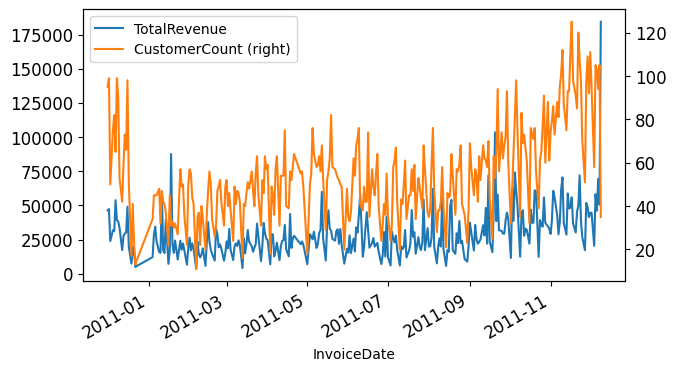

In [83]:
viz_df.set_index('InvoiceDate', inplace=True)
viz_df.plot(figsize=(7,4),fontsize=12, secondary_y='CustomerCount')

In [21]:
from datetime import datetime

date_rng = pd.date_range(start='2010-11-30', end='2011-11-30', freq='M')
churn =  {"Month":[],"ChurnRate":[], "AvgRevenue":[]}

#append first month without churn rate
this_period  =df[(df['InvoiceDate']> date_rng[0].date()) & (df['InvoiceDate']<= date_rng[1].date()) ]['CustomerID'].unique()
total_revenue =df[(df['InvoiceDate']> date_rng[0].date()) & (df['InvoiceDate']<= date_rng[1].date()) ]['Revenue'].sum()

churn["Month"].append(date_rng[1])
churn["ChurnRate"].append(np.nan)
churn["AvgRevenue"].append(int(total_revenue/len(this_period)))

#loop through the rest of the months
for i in range(len(date_rng)):
    try:
        last_period =df[(df['InvoiceDate']> date_rng[i].date()) & (df['InvoiceDate']<= date_rng[i+1].date()) ]['CustomerID'].unique()
        this_period  =df[(df['InvoiceDate']> date_rng[i+1].date()) & (df['InvoiceDate']<= date_rng[i+2].date()) ]['CustomerID'].unique()
        total_revenue =df[(df['InvoiceDate']> date_rng[i+1].date()) & (df['InvoiceDate']<= date_rng[i+2].date()) ]['Revenue'].sum()
        retained = np.intersect1d(last_period, this_period)
        churn["Month"].append(date_rng[i+2])
        churn["ChurnRate"].append((int((1-(len(retained)/len(last_period)))*100)))
        churn["AvgRevenue"].append(int(total_revenue/len(this_period)))
    except:
        pass

# Create churn_df DataFrame
churn_df = pd.DataFrame(churn)
churn_df

C:\Users\Admin\AppData\Local\Temp\ipykernel_10076\1383266157.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_rng = pd.date_range(start='2010-11-30', end='2011-11-30', freq='M')


,Month,ChurnRate,AvgRevenue
0,2010-12-31,NaN,647
1,2011-01-31,63.0,768
2,2011-02-28,64.0,589
3,2011-03-31,61.0,611
4,2011-04-30,68.0,548
5,2011-05-31,57.0,642
6,2011-06-30,61.0,667
7,2011-07-31,63.0,632
8,2011-08-31,59.0,690
9,2011-09-30,54.0,752


In [22]:
churn_df.mean().round(0)

Month         2011-06-15 12:00:00
ChurnRate               60.454545
AvgRevenue                  667.0
dtype: object

In [23]:
from lifetimes.plotting import *
from lifetimes.utils import *

data = summary_data_from_transaction_data(df, 'CustomerID', 'InvoiceDate',\
          monetary_value_col='Revenue', observation_period_end='2011-09-01')
data.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346,0.0,0.0,226.0,0.0000
12347,4.0,238.0,268.0,519.7675
12348,2.0,110.0,259.0,297.2200
12350,0.0,0.0,211.0,0.0000
12352,3.0,34.0,197.0,421.7700


In [24]:
cutoff_date = pd.to_datetime("2011-09-01").date()
end_date = pd.to_datetime("2011-12-01").date()

true_df = pd.DataFrame(df.loc[(df['InvoiceDate']>=cutoff_date)\
                              &(df['InvoiceDate']<end_date)]\
                       .groupby('CustomerID')['Revenue'].sum()).reset_index()

train_df = data.reset_index().merge(true_df).rename(columns={"Revenue":"y"})
train_df

,CustomerID,frequency,recency,T,monetary_value,y
0,12347,4.0,238.0,268.0,519.767500,1294.32
1,12348,2.0,110.0,259.0,297.220000,310.00
2,12352,3.0,34.0,197.0,421.770000,944.23
3,12356,1.0,80.0,226.0,481.460000,58.35
4,12359,2.0,142.0,232.0,1474.115000,2876.85
...,...,...,...,...,...,...
1873,18270,0.0,0.0,167.0,0.000000,171.20
1874,18272,3.0,133.0,147.0,488.876667,604.25
1875,18273,0.0,0.0,158.0,0.000000,102.00
1876,18283,7.0,189.0,238.0,125.331429,901.11


In [25]:
from lifetimes import BetaGeoFitter
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_df[['CustomerID',\
                           'frequency','recency', 'T','monetary_value']],\
                           train_df[['y']], test_size=0.3, random_state=42)

bgf = BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(X_train['frequency'], X_train['recency'], X_train['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 1314 subjects, a: 0.00, alpha: 44.90, b: 0.00, r: 0.72>


In [26]:
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
15311,61.0,261.0,274.0,732.480164,0.193551
14606,64.0,270.0,274.0,142.672812,0.202959
12748,69.0,272.0,274.0,196.573913,0.218638
17841,73.0,274.0,274.0,303.863699,0.231181
14911,80.0,274.0,274.0,972.027875,0.253132


In [28]:
data['predicted_alive'] = bgf.conditional_probability_alive(data['frequency'],data['recency'], data['T'])
data.sort_values(by='predicted_alive').head(5)

,frequency,recency,T,monetary_value,predicted_purchases,predicted_alive
CustomerID,,,,,,
17850,1.0,1.0,274.0,3891.87,0.005402,1.0
15332,1.0,3.0,270.0,63.00,0.005471,1.0
16499,1.0,4.0,265.0,147.35,0.005559,1.0
15224,1.0,4.0,263.0,310.48,0.005595,1.0
17198,1.0,6.0,272.0,249.65,0.005436,1.0


In [29]:
returning_customers_summary = X_train[X_train['frequency']>0]
print(returning_customers_summary.head())

      CustomerID  frequency  recency      T  monetary_value
1754       17838        2.0     80.0  273.0      485.270000
798        14715        1.0     33.0  232.0      109.500000
1820       18102       14.0    241.0  268.0     7472.632857
1469       16912        3.0    189.0  224.0      393.693333
58         12480        2.0    193.0  237.0      664.350000


In [30]:
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 961 subjects, p: 3.18, q: 3.20, v: 302.83>


In [38]:
pred = ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    X_test['frequency'],
    X_test['recency'],
    X_test['T'],
    X_test['monetary_value'],
    time=3, # months
    discount_rate=0 # monthly discount rate ~ 12.7% annually
).fillna(0)

pred_df

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


1111     175.167450
1448    2290.274120
1326     190.359216
807     1082.636798
270      336.737655
           ...     
1734     106.115523
358      107.717899
1041      89.477544
236      138.584806
551      154.324949
Name: clv, Length: 564, dtype: float64

In [46]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, pred_df)

805.323044194314

In [53]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
reg = RandomForestRegressor()
model = reg.fit(X_train.drop(columns='CustomerID'), y_train)

ml_pred = model.predict(X_test.drop(columns='CustomerID'))
mean_absolute_error(ml_pred, y_test['y'])

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


831.8831695058399